In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import matplotlib as mpl
from sklearn.cluster import KMeans
import dofitPython_functions as LogFit 

In [2]:
#xrdsNorESM = xr.open_dataset("/share/sabl0586/all_stations_NorESM_OsloAero_prcp2szdst_f19_f19_noresmv211_corr_ilev-1_4Peter.nc")
#SMRXRdsNorESM = xrdsNorESM.sel(station='SMR-II')


In [3]:
#xrdsNorESMall_levs = xr.open_dataset("/share/sabl0586/all_stations_NorESM_OsloAero_prcp2szdst_f19_f19_noresmv211_corr_ilevall_levs_4Peter.nc")
#SMRNorlevs =  xrdsNorESMall_levs.sel(station='SMR-II')
PeterNor =  xr.open_dataset('/share/pech2273/SMRPeterVariables2.nc')
PeterNor

<xarray.Dataset> Size: 38MB
Dimensions:  (time: 8761, lev: 32)
Coordinates:
  * time     (time) datetime64[ns] 70kB 2012-01-02 ... 2015-01-01
    station  <U6 24B ...
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
Data variables: (12/34)
    SIGMA01  (time, lev) float32 1MB ...
    NMR01    (time, lev) float32 1MB ...
    NCONC01  (time, lev) float32 1MB ...
    SIGMA02  (time, lev) float32 1MB ...
    NMR02    (time, lev) float32 1MB ...
    NCONC02  (time, lev) float32 1MB ...
    ...       ...
    NMR12    (time, lev) float32 1MB ...
    NCONC12  (time, lev) float32 1MB ...
    FREQL    (time, lev) float32 1MB ...
    AWNC     (time, lev) float32 1MB ...
    WSUB     (time, lev) float32 1MB ...
    T        (time, lev) float32 1MB ...

In [4]:
# OutputNor['PDF01'].assign(SMRNorlevs['PDF01'])
time = PeterNor.indexes['time']
lev = PeterNor.indexes['lev']
OutputNor = xr.Dataset( coords = dict(lev = lev, time = time))
Output= xr.Dataset( coords = dict( time = time))

In [5]:
def createNorESMDistributions(Data, Xspace):
    ds=xr.Dataset()
    for i in range(1,14):
        if f'SIGMA{i:02d}' not in Data:
            continue   
        Data[f'dNdlogD{i:02d}'] = dNdlogD(Data[f'NCONC{i:02d}'],Xspace, Data[f'NMR{i:02d}'], Data[f'SIGMA{i:02d}'])        
    return 

def dNdlogD(N,x,mu,sigma):
    return N*np.exp(-(np.log(x) - np.log(mu*2))**2 / (2 * np.log(sigma)**2))/ (np.log(sigma) * np.sqrt(2 * np.pi))    

In [6]:
x = xr.DataArray(np.logspace(-1.5,6, num=100), dims =['D'], coords= {'D':np.logspace(-1.5,6, num=100)})
createNorESMDistributions(PeterNor, x)

In [7]:


PeterNor['TotaldNdlogD']=PeterNor['dNdlogD01']
for i in range(2,14):
    if f'dNdlogD{i:02d}' not in PeterNor:
       continue
    PeterNor['TotaldNdlogD'] = PeterNor['TotaldNdlogD']+PeterNor[f'dNdlogD{i:02d}']

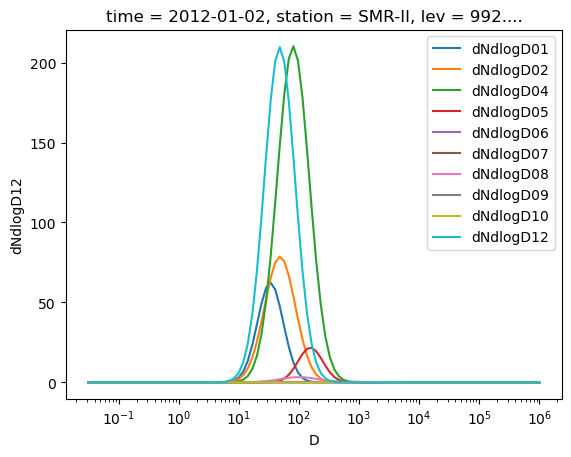

In [8]:

for i in range(1,14):
    if f'dNdlogD{i:02d}' not in PeterNor:
       continue
    PeterNor[f'dNdlogD{i:02d}'].isel(lev=-1, time = 0).plot(xscale='log', label = f'dNdlogD{i:02d}')
plt.legend()

Text(0.5, 1.0, 'NorESM Mean Aerosol Distribution for the First Layer')

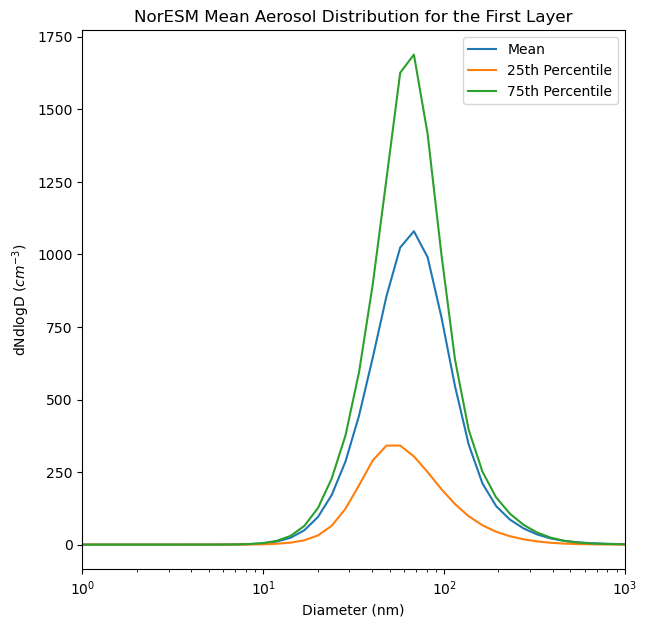

In [9]:
plt.figure(figsize = (7,7))
PeterNor['TotaldNdlogD'].isel(lev = -1).mean('time').plot(xscale = 'log',xlim = [1,1000], label = 'Mean')
PeterNor['TotaldNdlogD'].isel(lev = -1).quantile(0.25, dim='time').plot(label = '25th Percentile')
PeterNor['TotaldNdlogD'].isel(lev = -1).quantile(0.75, dim='time').plot(label = '75th Percentile')
plt.legend()
plt.xlabel('Diameter (nm)')
plt.ylabel('dNdlogD ($cm^{-3}$)')
plt.title('NorESM Mean Aerosol Distribution for the First Layer')


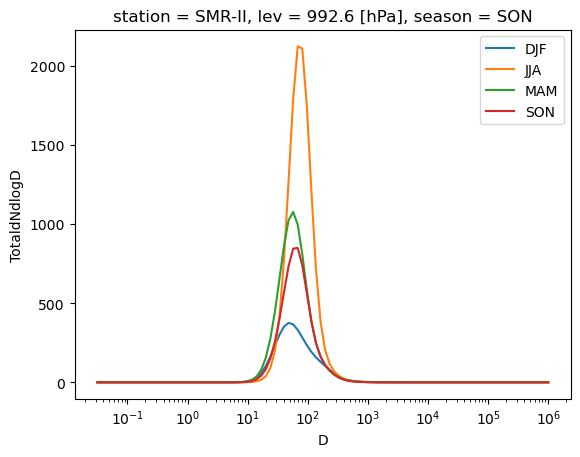

In [10]:
DS_ = PeterNor['TotaldNdlogD'].isel(lev = -1).groupby(PeterNor['time.season']).mean()
for seas in DS_.season:
    DS_.sel(season = seas).plot(xscale = 'log', label=seas.values)
#DS_.isel(season = 1).plot(xscale = 'log')
#DS_.isel(season = 2).plot(xscale = 'log')
#DS_.isel(season = 3).plot(xscale = 'log')
plt.legend()

In [11]:
dx = xr.DataArray(np.logspace(-1.5,6, num=100), dims =['Dx'], coords= {'Dx':np.logspace(-1.5,6, num=100)})
for i in range (1,len(dx)):
    dx[i]= np.log(x[i]/x[i-1])
dx[0]=dx[1]
deltax= dx[1]


In [12]:
def n70NorESM(Data, DeltaX = deltax):
    Data['Totaln70'] = Data['TotaldNdlogD'].where(Data['D']>70).sum('D')*DeltaX
    Data['Totaln50'] = Data['TotaldNdlogD'].where(Data['D']>50).sum('D')*DeltaX
    Data['Totaln150'] = Data['TotaldNdlogD'].where(Data['D']>150).sum('D')*DeltaX
    
    return 

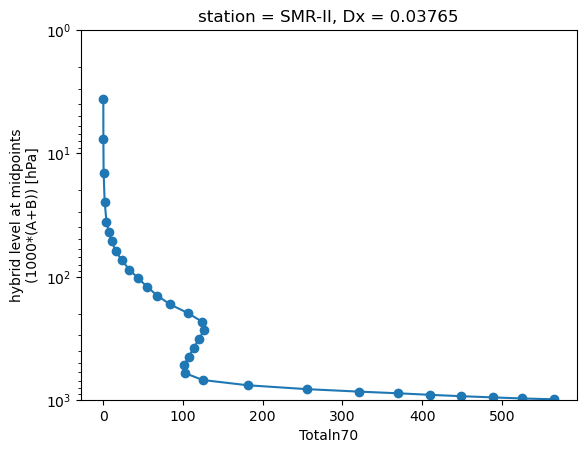

In [13]:
n70NorESM(PeterNor)
PeterNor['Totaln70'].mean('time').plot(y = 'lev', ylim = [1000,1], yscale = 'log', marker = 'o')

#plt.xlabel('CCN')


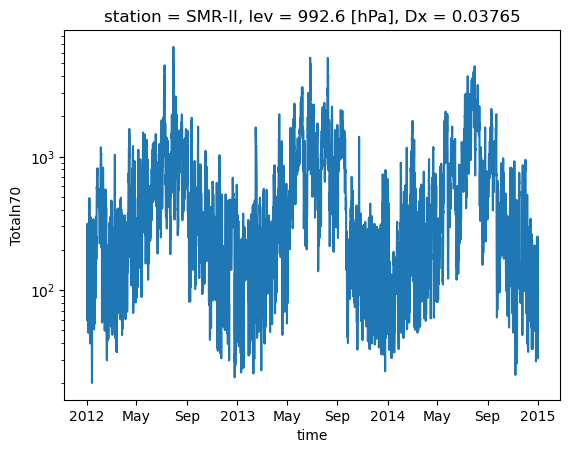

In [14]:
PeterNor['Totaln70'].isel(lev = -1).plot(yscale = 'log')

In [15]:
def DropletNumber(Data):
    Data['Droplets'] = Data['AWNC'].isel()/Data['FREQL']
    return 

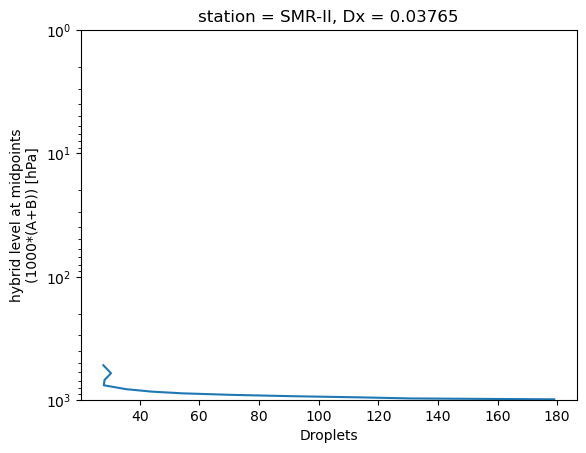

In [16]:
DropletNumber(PeterNor)
PeterNor['Droplets'].mean('time').plot(y = 'lev', ylim= [1000,1], yscale = 'log')


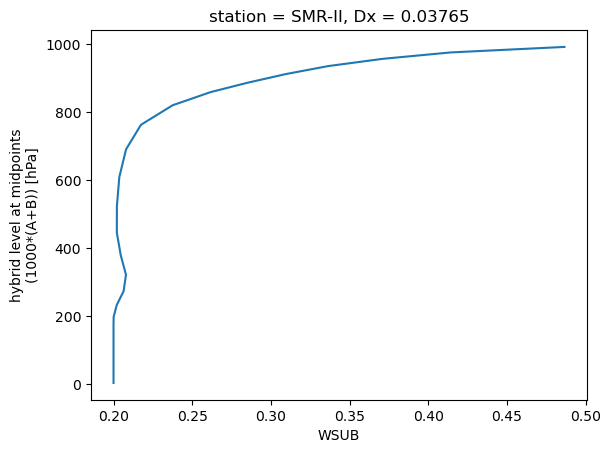

In [17]:
#plt.figure(figsize = (8,12))
#plt.subplot(3,1,1)
PeterNor['WSUB'].mean('time').plot(y = 'lev')
#plt.subplot(3,1,2)
#plt.hist(PeterNor['WSUB'].isel(lev = -2), bins = 20)
#plt.subplot(3,1,3)
#plt.hist(PeterNor['WSUB'].isel(lev = -3), bins = 20)

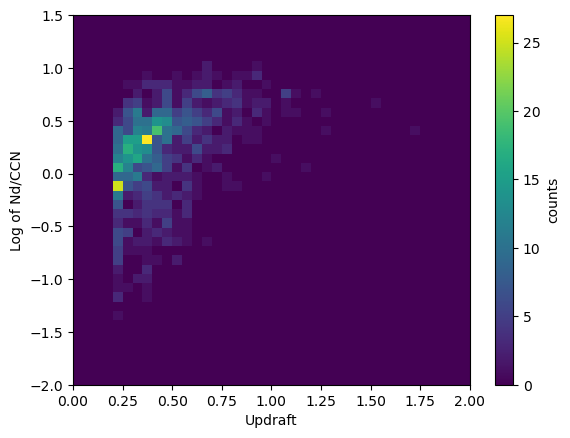

In [18]:
PeterNor['NdCCNRatio'] = PeterNor['Droplets']/PeterNor['Totaln70']


fig = plt.hist2d( PeterNor['WSUB'].isel(lev = -1),np.log10(PeterNor['NdCCNRatio'].isel(lev = -1)), bins = 40, range = [[0,2],[-2,1.5 ]]) #,gridsize=50, yscale='log', xscale='log',edgecolors = 'face', cmap = 'inferno', extent = [0,4,-2,1.5 ],  bins= 'log',)
plt.xlabel('Updraft')
plt.ylabel('Log of Nd/CCN')
plt.colorbar(label='counts')

Text(0, 0.5, 'Log of Nd/CCN')

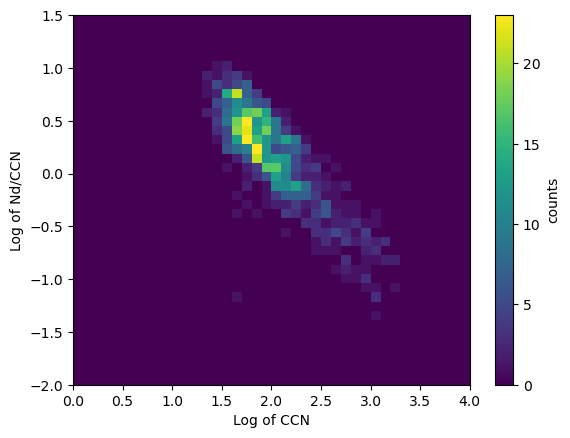

In [19]:
fig = plt.hist2d( np.log10(PeterNor['Totaln70'].isel(lev = -1)),np.log10(PeterNor['NdCCNRatio'].isel(lev = -1)), bins = 40, range = [[0,4],[-2,1.5 ]]) #,gridsize=50, yscale='log', xscale='log',edgecolors = 'face', cmap = 'inferno', extent = [0,4,-2,1.5 ],  bins= 'log',)

plt.colorbar(label='counts')
plt.xlabel('Log of CCN')
plt.ylabel('Log of Nd/CCN')
#plt.xlim(1,10000)
#plt.ylim(.01,17.5)


In [20]:
def NdtoCCNGraph(x,y):
    x = x.to_numpy()
    y = y.to_numpy()
    Y = np.log10(y)
    X = np.log10(x)
    X = sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    res = stats.linregress(np.log10(x),np.log10(y))
    lims = [1,10000]
    fig = plt.hexbin(x,y,gridsize=50, bins= 'log', xscale='log', yscale='log',edgecolors = 'face', cmap ='inferno',extent = [0,4,0,4], mincnt = 1)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot([1,10000],[10**res.intercept*1**res.slope,10**res.intercept*10000**res.slope])
    plt.plot(lims,lims)
    plt.colorbar(label='counts')
    plt.xlabel('CCN #$cm^{-3}$')
    plt.ylabel('Nd #$cm^{-3}$')
    print(model.summary())
    
    return fig

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.144
Date:                Thu, 27 Feb 2025   Prob (F-statistic):             0.0134
Time:                        15:54:12   Log-Likelihood:                 80.673
No. Observations:                 980   AIC:                            -157.3
Df Residuals:                     978   BIC:                            -147.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1040      0.039     53.814      0.0

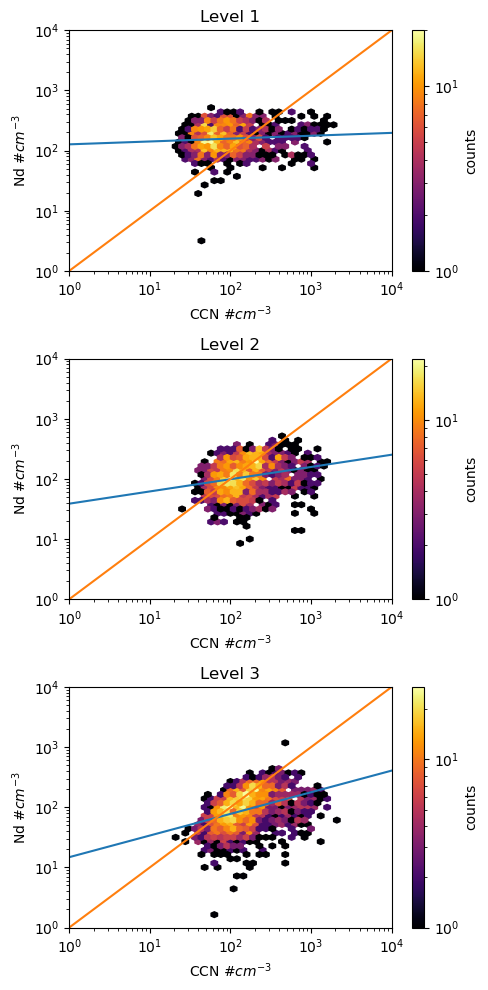

In [21]:
fig = plt.figure(figsize = (5,10))
x = PeterNor['Totaln70'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')
plt.subplot(3,1,1)
NdtoCCNGraph(x,y)
plt.title('Level 1')
x = PeterNor['Totaln70'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')
plt.subplot(3,1,2)
plt.title('Level 2')
NdtoCCNGraph(x,y)
x = PeterNor['Totaln70'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')
plt.subplot(3,1,3)
plt.title('Level 3')

NdtoCCNGraph(x,y)
plt.tight_layout()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.144
Date:                Thu, 27 Feb 2025   Prob (F-statistic):             0.0134
Time:                        15:54:13   Log-Likelihood:                 80.673
No. Observations:                 980   AIC:                            -157.3
Df Residuals:                     978   BIC:                            -147.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1040      0.039     53.814      0.0

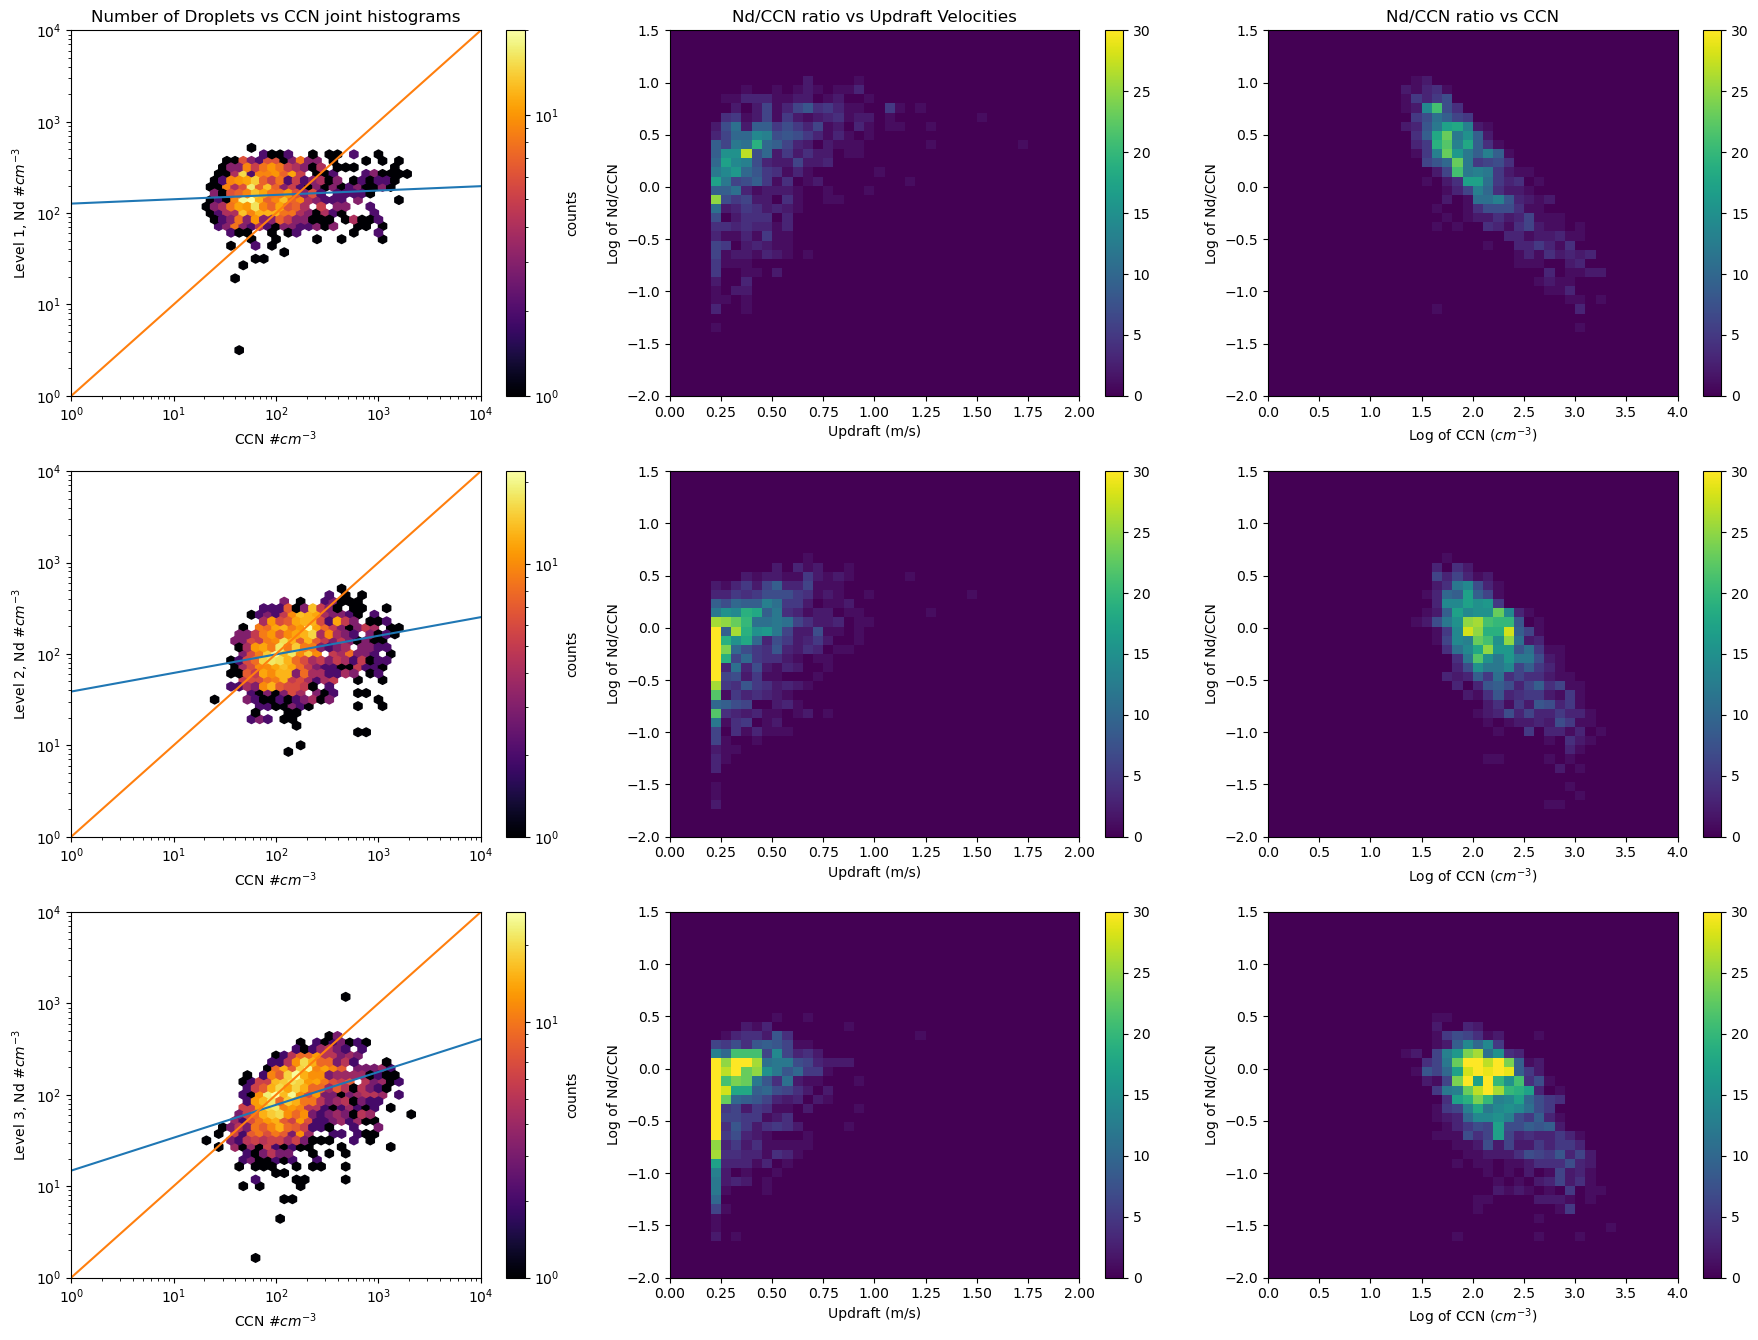

In [22]:
lims = [1,10000]
plt.figure(figsize = (18,13.5))
plt.subplot(3,3,1)
x = PeterNor['Totaln70'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')
NdtoCCNGraph(x,y)
plt.ylabel('Level 1, Nd #$cm^{-3}$')
plt.title('Number of Droplets vs CCN joint histograms')
plt.subplot(3,3,2)
plt.hist2d( PeterNor['WSUB'].isel(lev = -1),np.log10(PeterNor['NdCCNRatio'].isel(lev = -1)), bins = 40, range = [[0,2],[-2,1.5 ]], vmax = 30) #,gridsize=50, yscale='log', xscale='log',edgecolors = 'face', cmap = 'inferno', extent = [0,4,-2,1.5 ],  bins= 'log',)
plt.xlabel('Updraft (m/s)')
plt.ylabel('Log of Nd/CCN')
plt.colorbar()
plt.title('Nd/CCN ratio vs Updraft Velocities')

plt.subplot(3,3,3)
plt.hist2d( np.log10(PeterNor['Totaln70'].isel(lev = -1)),np.log10(PeterNor['NdCCNRatio'].isel(lev = -1)), bins = 40, range = [[0,4],[-2,1.5 ]], vmax = 30) #,gridsize=50, yscale='log', xscale='log',edgecolors = 'face', cmap = 'inferno', extent = [0,4,-2,1.5 ],  bins= 'log',)
plt.colorbar()
plt.xlabel('Log of CCN ($cm^{-3}$)')
plt.ylabel('Log of Nd/CCN')
plt.title('Nd/CCN ratio vs CCN')


plt.subplot(3,3,4)
x = PeterNor['Totaln70'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')

NdtoCCNGraph(x,y)
plt.ylabel('Level 2, Nd #$cm^{-3}$')

plt.subplot(3,3,5)
plt.hist2d( PeterNor['WSUB'].isel(lev = -2),np.log10(PeterNor['NdCCNRatio'].isel(lev = -2)), bins = 40, range = [[0,2],[-2,1.5 ]], vmax = 30) #,gridsize=50, yscale='log', xscale='log',edgecolors = 'face', cmap = 'inferno', extent = [0,4,-2,1.5 ],  bins= 'log',)
plt.xlabel('Updraft (m/s)')
plt.ylabel('Log of Nd/CCN')
plt.colorbar()

plt.subplot(3,3,6)
plt.hist2d( np.log10(PeterNor['Totaln70'].isel(lev = -2)),np.log10(PeterNor['NdCCNRatio'].isel(lev = -2)), bins = 40, range = [[0,4],[-2,1.5 ]], vmax = 30) #,gridsize=50, yscale='log', xscale='log',edgecolors = 'face', cmap = 'inferno', extent = [0,4,-2,1.5 ],  bins= 'log',)
plt.colorbar()
plt.xlabel('Log of CCN ($cm^{-3}$)')
plt.ylabel('Log of Nd/CCN')


plt.subplot(3,3,7)
x = PeterNor['Totaln70'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')

NdtoCCNGraph(x,y)
plt.ylabel('Level 3, Nd #$cm^{-3}$')


plt.subplot(3,3,8)
plt.hist2d( PeterNor['WSUB'].isel(lev = -3),np.log10(PeterNor['NdCCNRatio'].isel(lev = -3)), bins = 40, range = [[0,2],[-2,1.5 ]], vmax = 30) #,gridsize=50, yscale='log', xscale='log',edgecolors = 'face', cmap = 'inferno', extent = [0,4,-2,1.5 ],  bins= 'log',)
plt.xlabel('Updraft (m/s)')
plt.ylabel('Log of Nd/CCN')
plt.colorbar()

plt.subplot(3,3,9)
plt.hist2d( np.log10(PeterNor['Totaln70'].isel(lev = -3)),np.log10(PeterNor['NdCCNRatio'].isel(lev = -3)), bins = 40, range = [[0,4],[-2,1.5 ]], vmax = 30) #,gridsize=50, yscale='log', xscale='log',edgecolors = 'face', cmap = 'inferno', extent = [0,4,-2,1.5 ],  bins= 'log',)
plt.colorbar()
plt.xlabel('Log of CCN ($cm^{-3}$)')
plt.ylabel('Log of Nd/CCN')
plt.tight_layout()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1587
Date:                Thu, 27 Feb 2025   Prob (F-statistic):              0.690
Time:                        15:54:16   Log-Likelihood:                 77.684
No. Observations:                 980   AIC:                            -151.4
Df Residuals:                     978   BIC:                            -141.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2178      0.047     47.142      0.0

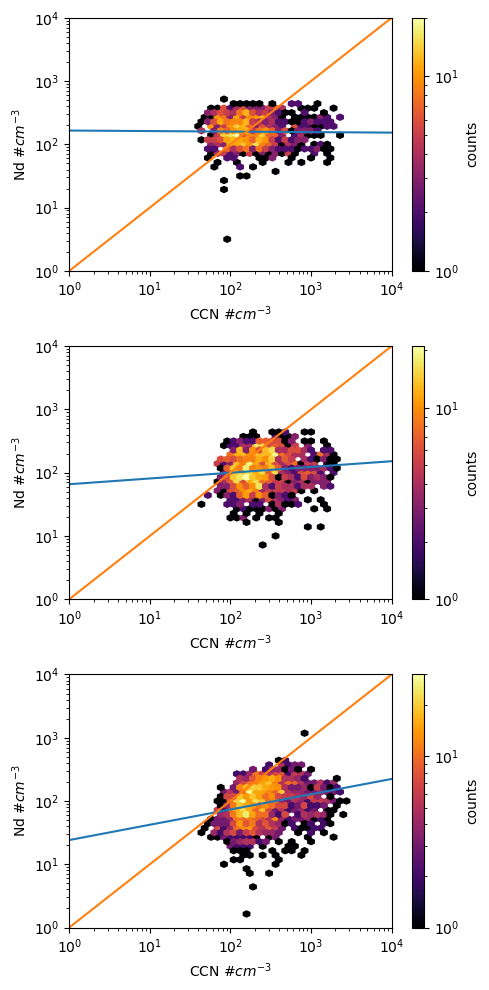

In [23]:
plt.figure(figsize = (5,10))
x = PeterNor['Totaln50'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')
plt.subplot(3,1,1)
NdtoCCNGraph(x,y)
x = PeterNor['Totaln50'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')
plt.subplot(3,1,2)

NdtoCCNGraph(x,y)
x = PeterNor['Totaln50'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')
plt.subplot(3,1,3)

NdtoCCNGraph(x,y)
plt.tight_layout()

N150, Updraft with height, reason to exclude first level? 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     282.2
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           7.65e-56
Time:                        15:54:17   Log-Likelihood:                 201.84
No. Observations:                 980   AIC:                            -399.7
Df Residuals:                     978   BIC:                            -389.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8601      0.021     87.972      0.0

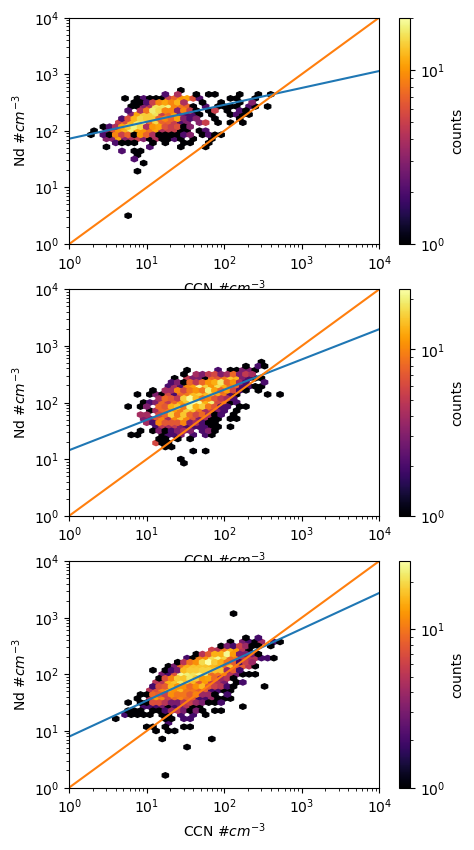

In [24]:
plt.figure(figsize = (5,10))
x = PeterNor['Totaln150'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')
plt.subplot(3,1,1)
NdtoCCNGraph(x,y)
x = PeterNor['Totaln150'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')
plt.subplot(3,1,2)

NdtoCCNGraph(x,y)
x = PeterNor['Totaln150'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')
plt.subplot(3,1,3)

NdtoCCNGraph(x,y)

In [25]:
PeterNor_seasons = PeterNor.groupby(PeterNor['time.season'])

In [26]:
def seasonalgraph(Dataset, Season, maxlevel, maxseasonnumber):
    #plt.figure(figsize=(10,15))   
    for i in range(1,maxlevel):
        
        x = Dataset[Season]['Totaln70'].isel(lev =- i).where(Dataset[Season]['Droplets'].isel(lev =-i)>0).dropna('time')
        y = Dataset[Season]['Droplets'].isel(lev =- i).where(Dataset[Season]['Droplets'].isel(lev =-i)>0).dropna('time')
        x  =x.to_numpy()
        y = y.to_numpy()
        res = stats.linregress(np.log10(x),np.log10(y))
        Y = np.log10(y)
        X = np.log10(x)
        X = sm.add_constant(X)
        model = sm.OLS(Y,X).fit()
        print(f'{Season}')
        print('Level ' f'{i}')
        print(model.summary())
        if Season == 'DJF':
            fig = NdtoCCNGraphseason(1,i,maxlevel,x,y,res, maxseasonnumber)
        if Season == 'MAM':
            fig = NdtoCCNGraphseason(2,i,maxlevel,x,y,res, maxseasonnumber)
        if Season == 'JJA':
            fig = NdtoCCNGraphseason(3,i,maxlevel,x,y,res, maxseasonnumber)
        if Season == 'SON':
            fig = NdtoCCNGraphseason(4,i,maxlevel,x,y,res, maxseasonnumber)
    return fig

def NdtoCCNGraphseason(seasonnumber,level, maxlevel, x,y,res,maxseasonnumber):
    lims = [1,10000]
    fig = plt.subplot(maxseasonnumber,maxlevel-1,level+(seasonnumber-1)*(maxlevel-1))
    plt.hexbin(x,y,gridsize=50, bins= 'log', xscale='log', yscale='log',edgecolors = 'face', cmap ='inferno',extent = [0,4,0,4], mincnt = 1)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot([1,10000],[10**res.intercept*1**res.slope,10**res.intercept*10000**res.slope])
    plt.plot(lims,lims)
    plt.colorbar(label='counts')
    plt.xlabel('CCN')
    plt.ylabel('Nd')
    
    return fig

DJF
Level 1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     38.05
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           1.48e-09
Time:                        15:54:19   Log-Likelihood:                 77.258
No. Observations:                 476   AIC:                            -150.5
Df Residuals:                     474   BIC:                            -142.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7022      0.084     20.

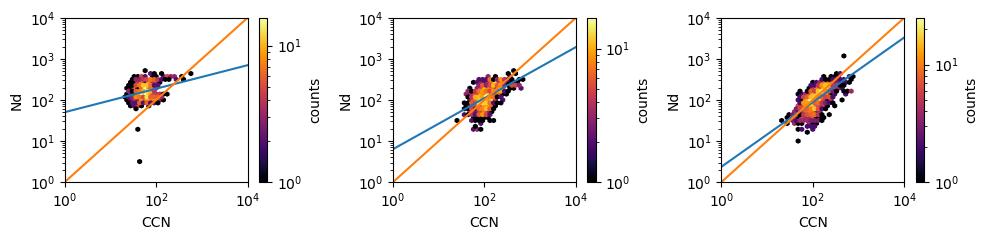

In [27]:
season = ['DJF']#, 'MAM','JJA','SON']
plt.figure(figsize = (10,2.5))
for seas in season: 
    seasonalgraph(PeterNor_seasons,seas,4,1)
    plt.tight_layout()

DJF
Level 1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     38.05
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           1.48e-09
Time:                        15:54:23   Log-Likelihood:                 77.258
No. Observations:                 476   AIC:                            -150.5
Df Residuals:                     474   BIC:                            -142.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7022      0.084     20.

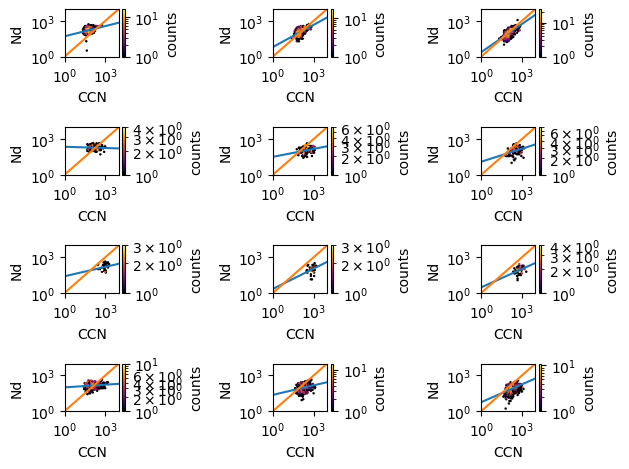

In [28]:
season = ['DJF', 'MAM','JJA','SON']
for seas in season: 
    fig = seasonalgraph(PeterNor_seasons,seas,4,4)
    #fig.tight_layout()
    plt.tight_layout()
    plt.savefig('plots/seasonal_fig_noresm.png')#, dpi=200)

Frequency of clouds?


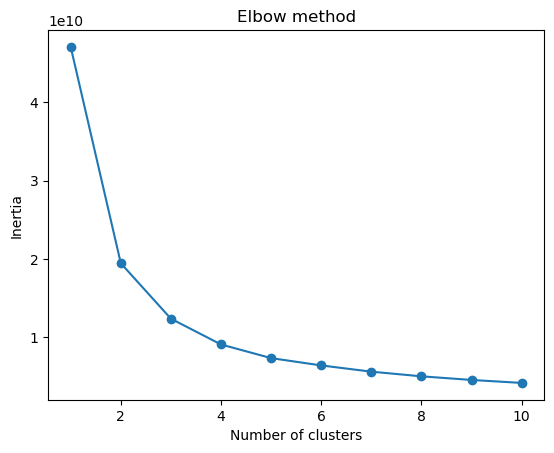

In [29]:
sizedist4clust =PeterNor['TotaldNdlogD'].isel(lev=-1)
sizedist4clust=sizedist4clust.dropna(dim='time')
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state = 2)
    kmeans.fit(sizedist4clust)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [30]:
kmeans = KMeans(n_clusters=4,random_state=2)
kmeans.fit(sizedist4clust)

myds = sizedist4clust.to_dataset()
myds['label'] = xr.DataArray(kmeans.labels_, dims=('time'))
myds

<xarray.Dataset> Size: 7MB
Dimensions:       (time: 8761, D: 100)
Coordinates:
  * time          (time) datetime64[ns] 70kB 2012-01-02 ... 2015-01-01
    station       <U6 24B ...
    lev           float64 8B 992.6
  * D             (D) float64 800B 0.03162 0.03765 0.04482 ... 8.399e+05 1e+06
    Dx            float64 8B 0.03765
Data variables:
    TotaldNdlogD  (time, D) float64 7MB 9.65e-27 1.317e-25 ... 1.204e-26
    label         (time) int32 35kB 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3

In [31]:
myds_med = myds['TotaldNdlogD'].groupby(myds['label']).median()

(1, 1000)

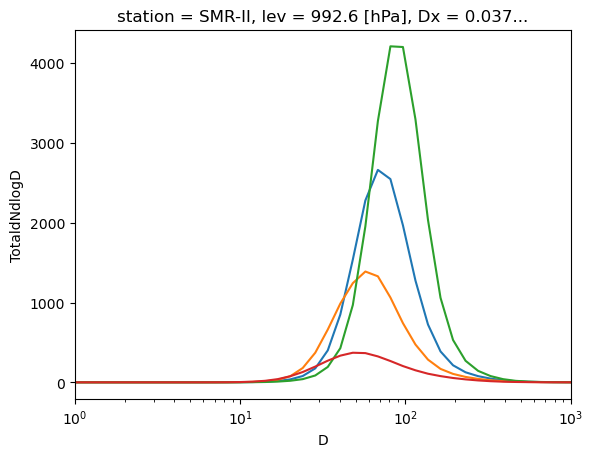

In [32]:
for l in myds_med.label:
    myds_med.sel(label=l).plot()
    plt.xscale('log')
plt.xlim([1,1000])

In [33]:
def log_distrib(Dpg,sig,Ntot,Dp):
    return Ntot * 0.39894228 / np.log10(sig) * np.exp(-0.5*(np.log10(Dp)-np.log10(Dpg))**2/(np.log10(sig)**2))

def style(ax):
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)
        ax.spines[axis].set_color('k')
    plt.rc('axes', linewidth=0.2)
    fontsize = 12
    ax = plt.gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    ax.tick_params(direction='out', length=8, width=1.3, pad=10, bottom=True, top=False, left=True, right=False, color='k')
    ax.tick_params(which='minor', length=4, color='k', width=1.3)
    
def plot_fit(Dp, distrib, estimate, ax):
    for i in range(len(estimate)):
        plt.plot(Dp,estimate[i], '--', label='fit mode ' + str(i), color='b')
    plt.plot(Dp,sum(estimate), label='fit', color='b', linewidth=3, alpha=0.6)
    plt.plot(Dp,distrib, color='r', label='measured', linewidth=3, alpha=0.6)
    ax.set_xscale('log')
    plt.legend()
    ax.grid(True, alpha=0.6)
    ax.set_xlabel(r'Dp ($nm$)', fontsize=15)
    style(ax)
    ax.set_ylabel(r'dN/dlogDg ($cm^{-3}$)', fontsize=15)
    ax.set_xlim([1,1000])
    ax.set_xticks([1,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000])
    ax.set_xticklabels([1,10,'',30,'','','','','','',100,'','','', '', '', '', '', '', 1000])

In [34]:
df = pd.DataFrame(PeterNor['TotaldNdlogD'].isel(lev = 0).mean('time'))
Dp = pd.DataFrame(PeterNor['D'])
Dp_ = Dp*1E-9
estimate = []
for l in myds_med.label:
    estimate.append(LogFit.fit_3_modes(myds_med['D']*1E-9, myds_med.sel(label = l),'yes'))

In [35]:
estimate

[[[np.float64(1.2898933542075269e-08),
   np.float64(7.000000000000002e-08),
   np.float64(7.536654796421419e-08)],
  array([1.5, 1.5, 1.5]),
  array([[  2.90582482],
         [679.78761041],
         [478.19388057]])],
 [[np.float64(2.0744501908140974e-07),
   np.float64(5.144070722964592e-08),
   np.float64(7.536654796421419e-08)],
  array([1.5, 1.5, 1.5]),
  array([[ 26.67666298],
         [432.42852033],
         [242.82618696]])],
 [[np.float64(6.680969967026435e-08),
   np.float64(9.52553000122065e-08),
   np.float64(8.235890550984322e-08)],
  [np.float64(1.4500000000000004),
   np.float64(1.4500000000000004),
   np.float64(1.3000000000000003)],
  array([[ 169.01624528],
         [1196.81709523],
         [ 332.14582491]])],
 [[np.float64(3.336201074400112e-08),
   np.float64(5.555903681888707e-08),
   np.float64(1.2834243687093023e-07)],
  array([1.5, 1.5, 1.5]),
  array([[ 55.80377985],
         [134.86485242],
         [ 40.08283547]])]]

In [36]:
Dpg = []
Ntot = []
sig = []
for i in range(len(estimate)):
    Dpg.append(estimate[i][0])
    sig.append(estimate[i][1])
    Ntot.append(estimate[i][2])

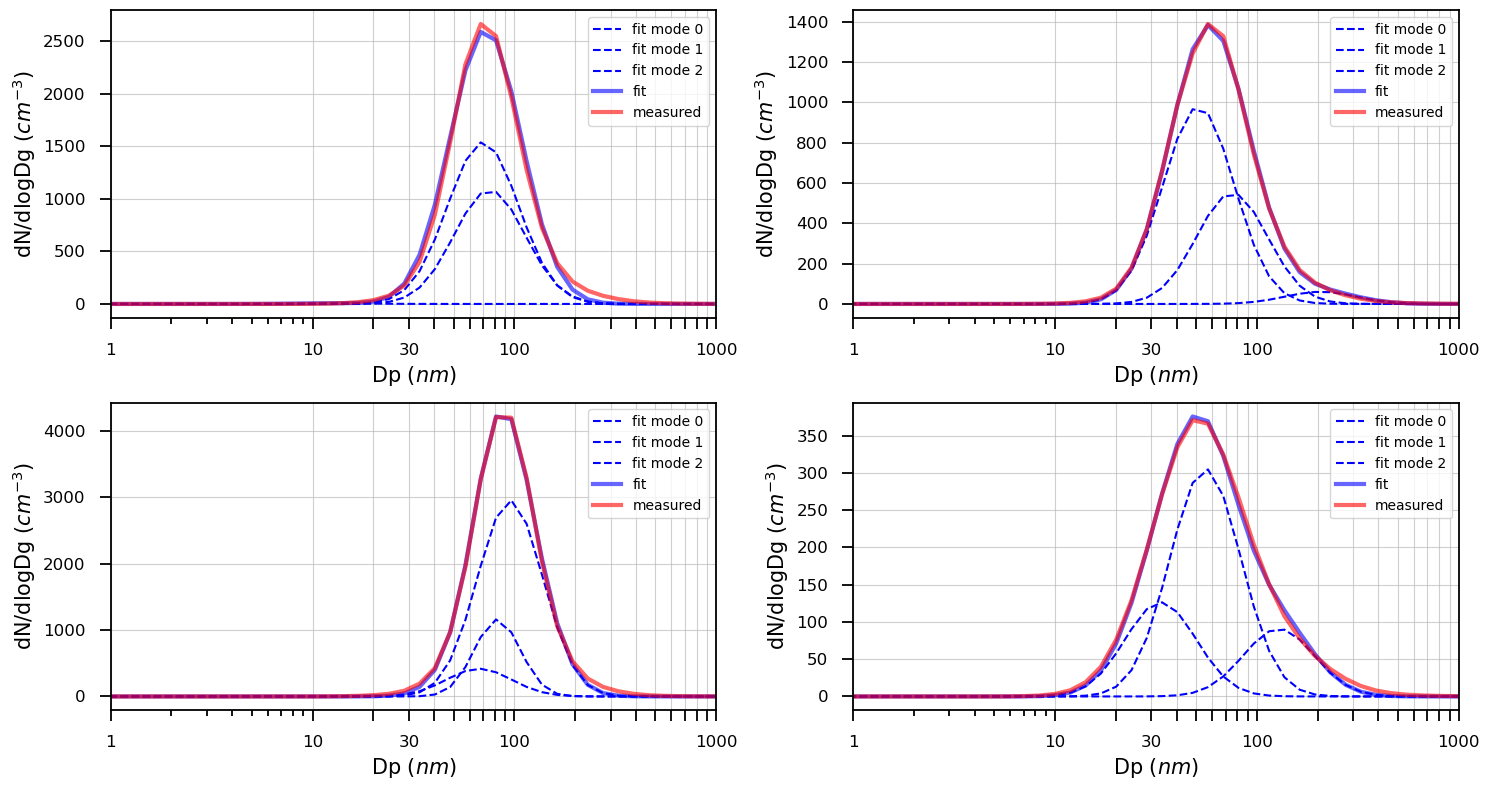

In [37]:
fig = plt.figure(num=None, figsize=(15,8))
for i in range(0,4):
    distributions = [log_distrib(Dpg[i][j],sig[i][j],Ntot[i][j],Dp_) for j in range(len(Dpg[i]))]
    ax = fig.add_subplot(2,2, i+1)
    plot_fit(Dp_*1e9, myds_med.sel(label = i), distributions, ax)
fig.tight_layout()

In [38]:
Temp_ds = PeterNor['T'].isel(lev = -1).dropna('time').groupby(myds['label']).mean()

In [39]:
DpgArray = xr.DataArray(Dpg)

NtotArray = xr.DataArray(Ntot)
NtotArray = NtotArray.squeeze()
SigArray = xr.DataArray(sig)
Means_ds = xr.Dataset({'Dpg': (['KmeansLabel','Distribution Number'], DpgArray.data), 'Ntot': (['KmeansLabel','Distribution Number'], NtotArray.data), 'Temperature':(['KmeansLabel'],Temp_ds.data), 'Sig': (['KmeansLabel','Distribution Number'], SigArray.data)})


In [40]:
!rm /share/pech2273/NorESMKmeans.nc
Means_ds.to_netcdf('/share/pech2273/NorESMKmeans.nc')

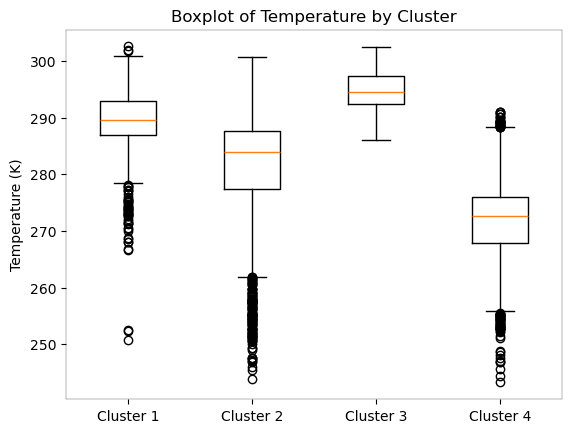

In [41]:
plt.boxplot([PeterNor['T'].isel(lev = -1).where(myds['label'] == 0, drop = True),PeterNor['T'].isel(lev = -1).where(myds['label'] == 1, drop = True), PeterNor['T'].isel(lev = -1).where(myds['label'] == 2, drop = True),\
             PeterNor['T'].isel(lev = -1).where(myds['label'] == 3, drop = True)], labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('Boxplot of Temperature by Cluster')
plt.ylabel('Temperature (K)')
plt.show()

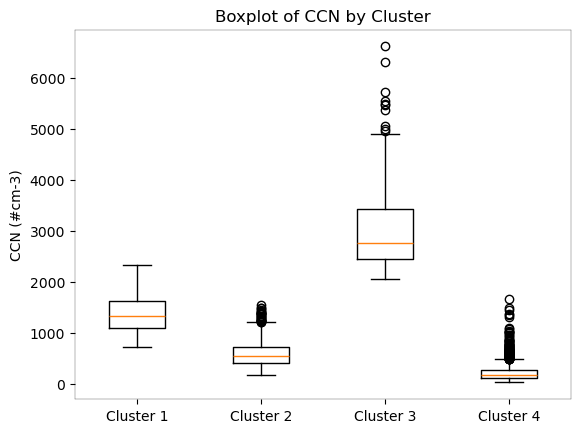

In [42]:
plt.boxplot([PeterNor['Totaln70'].isel(lev = -1).where(myds['label'] == 0, drop = True),PeterNor['Totaln70'].isel(lev = -1).where(myds['label'] == 1, drop = True), PeterNor['Totaln70'].isel(lev = -1).where(myds['label'] == 2, drop = True),\
             PeterNor['Totaln70'].isel(lev = -1).where(myds['label'] == 3, drop = True)], labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.title('Boxplot of CCN by Cluster')
plt.ylabel('CCN (#cm-3)')
plt.show()

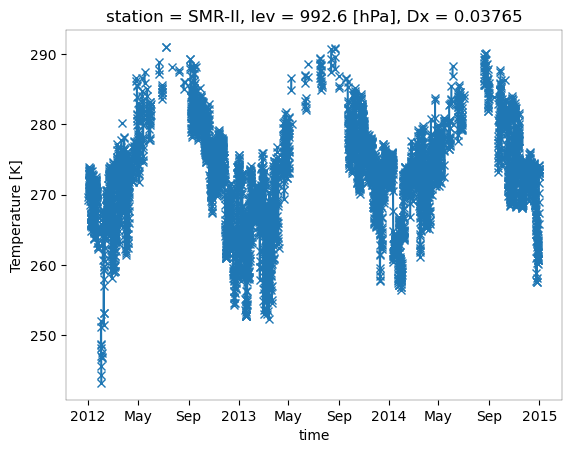

In [43]:
PeterNor['T'].isel(lev = -1).where(myds['label'] == 3).plot(marker = 'x')

(array([  2.,   3.,   5.,   0.,   8.,  22.,  25.,  71., 109., 162., 253.,
        264., 299., 420., 513., 755., 596., 389., 282., 213., 172., 105.,
         59.,  36.,  17.]),
 array([243.22596741, 245.13795471, 247.04994202, 248.96192932,
        250.87391663, 252.78590393, 254.69789124, 256.60986328,
        258.52185059, 260.43383789, 262.3458252 , 264.2578125 ,
        266.1697998 , 268.08178711, 269.99377441, 271.90576172,
        273.81774902, 275.72973633, 277.64172363, 279.55371094,
        281.46569824, 283.37768555, 285.28967285, 287.20166016,
        289.11364746, 291.02563477]),
 <BarContainer object of 25 artists>)

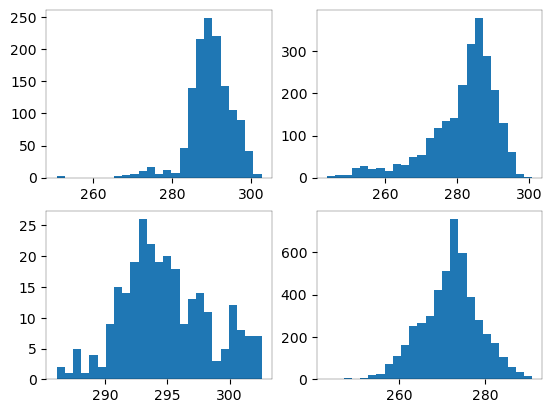

In [44]:

plt.subplot(2,2,1)
plt.hist(PeterNor['T'].isel(lev = -1).where(myds['label'] ==0), bins = 25)
plt.subplot(2,2,2)
plt.hist(PeterNor['T'].isel(lev = -1).where(myds['label'] ==1), bins = 25)
plt.subplot(2,2,3)
plt.hist(PeterNor['T'].isel(lev = -1).where(myds['label'] ==2), bins = 25)
plt.subplot(2,2,4)
plt.hist(PeterNor['T'].isel(lev = -1).where(myds['label'] ==3), bins = 25)

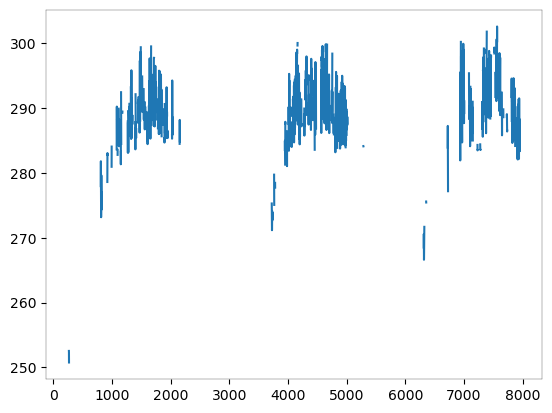

In [45]:
plt.plot(PeterNor['T'].isel(lev = -1).where(myds['label'] ==0))
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc9b0526090>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc83cda3200>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc9b0525a90>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc9b065d8b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc83c959070>],
 'means': []}

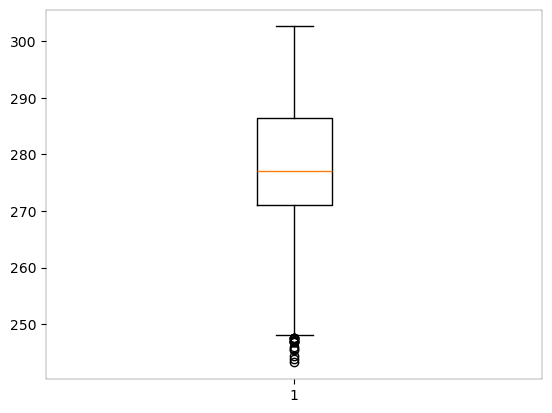

In [46]:
plt.boxplot(PeterNor['T'].isel(lev = -1))

In [47]:
myds['time_of_day'] = myds['time.hour'] 
myds['day_of_year'] = myds['time.dayofyear'] 


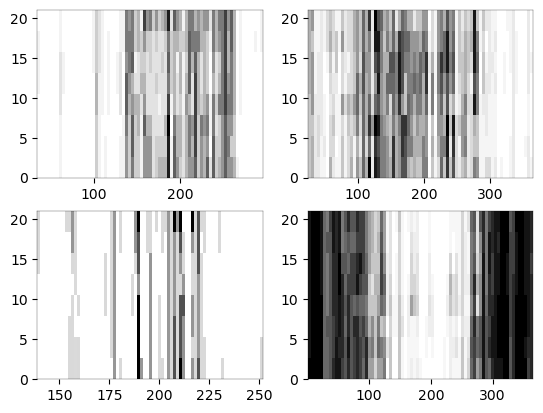

In [48]:

plt.subplot(2,2,1)
plt.hist2d(myds['day_of_year'].where(myds['label'] ==0, drop = 'true'), myds['time_of_day'].where(myds['label'] ==0, drop = 'true'), bins = [75,8], density = 'true', cmap = 'Greys')
plt.subplot(2,2,2)
plt.hist2d(myds['day_of_year'].where(myds['label'] ==1, drop = 'true'), myds['time_of_day'].where(myds['label'] ==1, drop = 'true'), bins = [75,8], density = 'true', cmap = 'Greys')
plt.subplot(2,2,3)
plt.hist2d(myds['day_of_year'].where(myds['label'] ==2, drop = 'true'), myds['time_of_day'].where(myds['label'] ==2, drop = 'true'), bins = [75,8], density = 'true', cmap = 'Greys')
plt.subplot(2,2,4)
plt.hist2d(myds['day_of_year'].where(myds['label'] ==3, drop = 'true'), myds['time_of_day'].where(myds['label'] ==3, drop = 'true'), bins = [75,8], density = 'true', cmap = 'Greys')
plt.show()

In [49]:
NorMassFrac_ds = xr.open_dataset('/share/pech2273/NorMassFrac.nc')

In [50]:
BCNorMassFracMeans = NorMassFrac_ds['BCMassFrac'].dropna('time').isel(lev = -1).groupby(myds['label']).mean()
OANorMassFracMeans = NorMassFrac_ds['OAMassFrac'].dropna('time').isel(lev = -1).groupby(myds['label']).mean()
SO4NorMassFracMeans = NorMassFrac_ds['SO4MassFrac'].dropna('time').isel(lev = -1).groupby(myds['label']).mean()
SeasaltNorMassFracMeans = NorMassFrac_ds['SeasaltMassFrac'].dropna('time').isel(lev = -1).groupby(myds['label']).mean()
DustNorMassFracMeans = NorMassFrac_ds['DustMassFrac'].dropna('time').isel(lev = -1).groupby(myds['label']).mean()

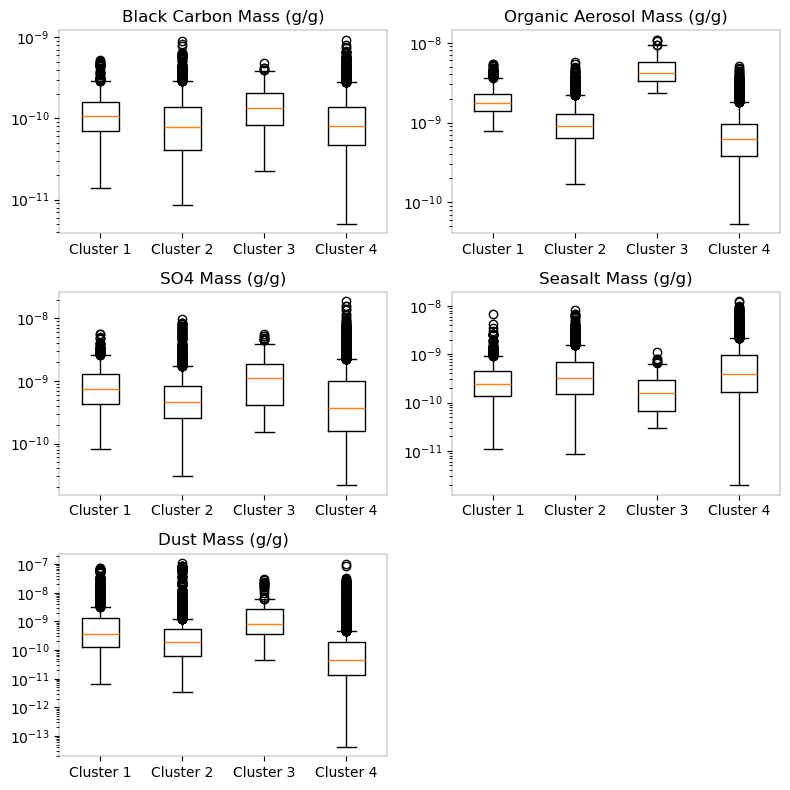

In [51]:
plt.figure(figsize = (8,8))
plt.subplot(3,2,1)
plt.title('Black Carbon Mass (g/g)')
plt.boxplot([NorMassFrac_ds['BCMass'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True),NorMassFrac_ds['BCMass'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True),\
            NorMassFrac_ds['BCMass'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True),NorMassFrac_ds['BCMass'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.yscale('log')
plt.subplot(3,2,2)
plt.title('Organic Aerosol Mass (g/g)')
plt.boxplot([NorMassFrac_ds['OAMass'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True),NorMassFrac_ds['OAMass'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True),\
            NorMassFrac_ds['OAMass'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True),NorMassFrac_ds['OAMass'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.yscale('log')
plt.subplot(3,2,3)
plt.yscale('log')
plt.title('SO4 Mass (g/g)')
plt.boxplot([NorMassFrac_ds['SO4Mass'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True),NorMassFrac_ds['SO4Mass'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True),\
            NorMassFrac_ds['SO4Mass'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True),NorMassFrac_ds['SO4Mass'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.subplot(3,2,4)
plt.yscale('log')
plt.title('Seasalt Mass (g/g)')
plt.boxplot([NorMassFrac_ds['SeasaltMass'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True),NorMassFrac_ds['SeasaltMass'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True),\
            NorMassFrac_ds['SeasaltMass'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True),NorMassFrac_ds['SeasaltMass'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.subplot(3,2,5)
plt.yscale('log')
plt.title('Dust Mass (g/g)')
plt.boxplot([NorMassFrac_ds['DustMass'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True),NorMassFrac_ds['DustMass'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True),\
            NorMassFrac_ds['DustMass'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True),NorMassFrac_ds['DustMass'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.tight_layout()
plt.show()

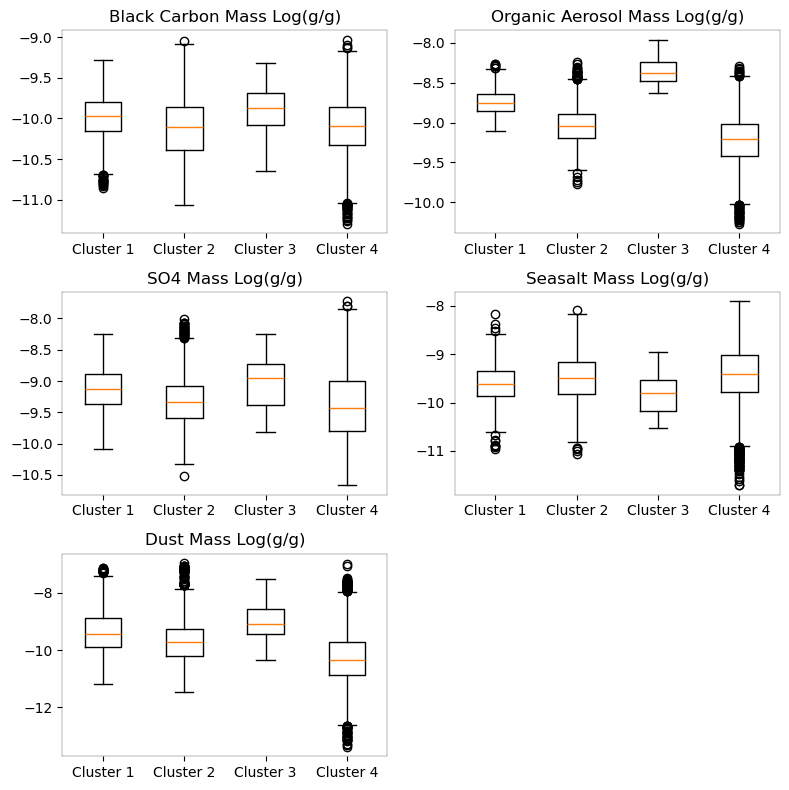

In [52]:
plt.figure(figsize = (8,8))
plt.subplot(3,2,1)
plt.title('Black Carbon Mass Log(g/g)')
plt.boxplot([np.log10(NorMassFrac_ds['BCMass'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True)),np.log10(NorMassFrac_ds['BCMass'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True)),\
            np.log10(NorMassFrac_ds['BCMass'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True)),np.log10(NorMassFrac_ds['BCMass'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True))],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.subplot(3,2,2)
plt.title('Organic Aerosol Mass Log(g/g)')
plt.boxplot([np.log10(NorMassFrac_ds['OAMass'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True)),np.log10(NorMassFrac_ds['OAMass'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True)),\
            np.log10(NorMassFrac_ds['OAMass'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True)),np.log10(NorMassFrac_ds['OAMass'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True))],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.subplot(3,2,3)
plt.title('SO4 Mass Log(g/g)')
plt.boxplot([np.log10(NorMassFrac_ds['SO4Mass'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True)),np.log10(NorMassFrac_ds['SO4Mass'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True)),\
            np.log10(NorMassFrac_ds['SO4Mass'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True)),np.log10(NorMassFrac_ds['SO4Mass'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True))],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.subplot(3,2,4)
plt.title('Seasalt Mass Log(g/g)')
plt.boxplot([np.log10(NorMassFrac_ds['SeasaltMass'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True)),np.log10(NorMassFrac_ds['SeasaltMass'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True)),\
            np.log10(NorMassFrac_ds['SeasaltMass'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True)),np.log10(NorMassFrac_ds['SeasaltMass'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True))],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.subplot(3,2,5)
plt.title('Dust Mass Log(g/g)')
plt.boxplot([np.log10(NorMassFrac_ds['DustMass'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True)),np.log10(NorMassFrac_ds['DustMass'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True)),\
            np.log10(NorMassFrac_ds['DustMass'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True)),np.log10(NorMassFrac_ds['DustMass'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True))],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.tight_layout()
plt.show()

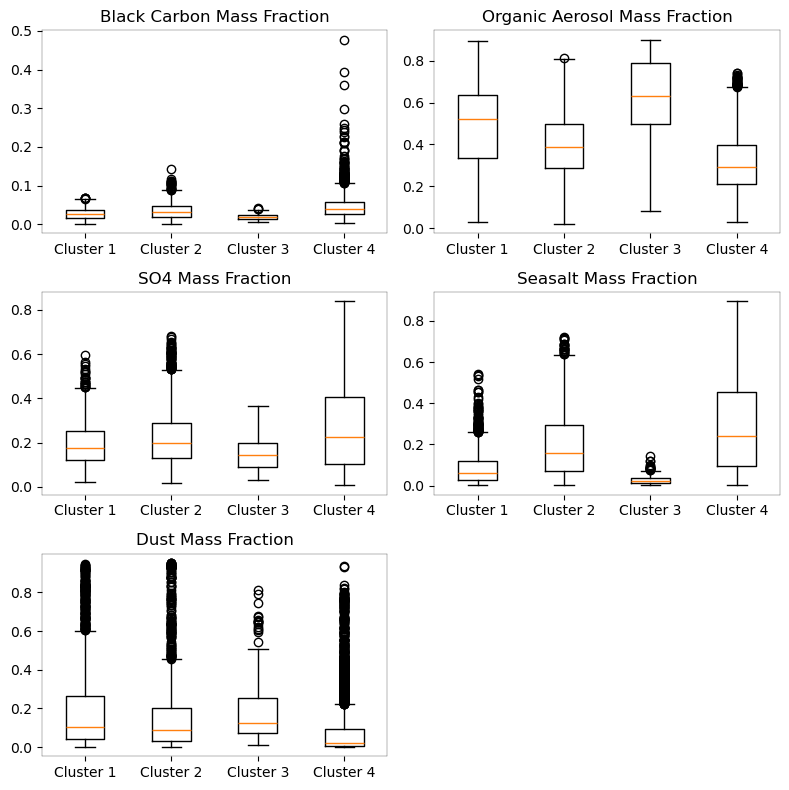

In [53]:
plt.figure(figsize = (8,8))
plt.subplot(3,2,1)
plt.title('Black Carbon Mass Fraction')
plt.boxplot([NorMassFrac_ds['BCMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True),NorMassFrac_ds['BCMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True),\
            NorMassFrac_ds['BCMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True),NorMassFrac_ds['BCMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.subplot(3,2,2)
plt.title('Organic Aerosol Mass Fraction')
plt.boxplot([NorMassFrac_ds['OAMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True),NorMassFrac_ds['OAMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True),\
            NorMassFrac_ds['OAMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True),NorMassFrac_ds['OAMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.subplot(3,2,3)
plt.title('SO4 Mass Fraction')
plt.boxplot([NorMassFrac_ds['SO4MassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True),NorMassFrac_ds['SO4MassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True),\
            NorMassFrac_ds['SO4MassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True),NorMassFrac_ds['SO4MassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.subplot(3,2,4)
plt.title('Seasalt Mass Fraction')
plt.boxplot([NorMassFrac_ds['SeasaltMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True),NorMassFrac_ds['SeasaltMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True),\
            NorMassFrac_ds['SeasaltMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True),NorMassFrac_ds['SeasaltMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.subplot(3,2,5)
plt.title('Dust Mass Fraction')
plt.boxplot([NorMassFrac_ds['DustMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 0, drop = True),NorMassFrac_ds['DustMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 1, drop = True),\
            NorMassFrac_ds['DustMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 2, drop = True),NorMassFrac_ds['DustMassFrac'].dropna('time').isel(lev = -1).where(myds['label'] == 3, drop = True)],\
           labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.tight_layout()
plt.show()

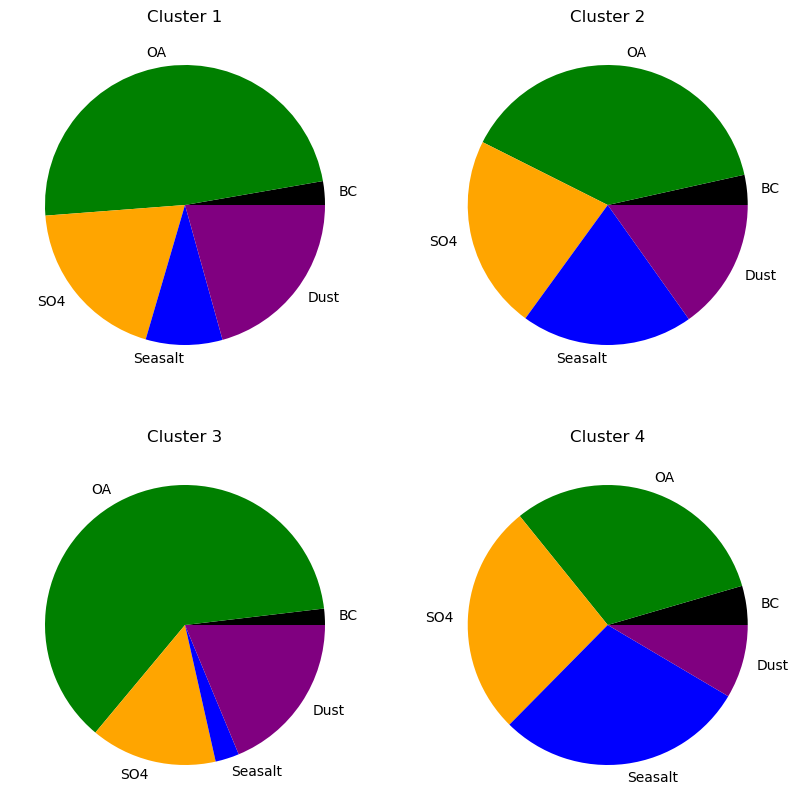

In [54]:
plt.figure(figsize = (10,10))
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.title(f'Cluster {i}')
    plt.pie([BCNorMassFracMeans[i-1],OANorMassFracMeans[i-1],SO4NorMassFracMeans[i-1], SeasaltNorMassFracMeans[i-1], DustNorMassFracMeans[i-1]], labels = ['BC','OA','SO4','Seasalt', 'Dust'],colors=['black', 'green','orange','blue','purple'])
plt.show()

In [55]:
SeasaltNorMassFracMeans

<xarray.DataArray 'SeasaltMassFrac' (label: 4)> Size: 16B
array([0.08855984, 0.19833036, 0.02746221, 0.28896123], dtype=float32)
Coordinates:
    station  <U6 24B ...
    lev      float64 8B 992.6
  * label    (label) int32 16B 0 1 2 3

In [56]:
NorMassFracMeans_ds = xr.Dataset({'BCMassFrac' : BCNorMassFracMeans, 'OAMassFrac' :OANorMassFracMeans,'SO4MassFrac' : SO4NorMassFracMeans, 'SeasaltMassFrac' :SeasaltNorMassFracMeans, 'DustMassFrac' :DustNorMassFracMeans})

In [57]:
#estimate.to_netcdf('/share/pech2273/NorDistibutionforPARSEC.nc')
!rm /share/pech2273/NorMassFracforPARSEC.nc
NorMassFracMeans_ds.to_netcdf('/share/pech2273/NorMassFracforPARSEC.nc')

In [58]:
print(len(myds.where(myds['label']==0)))

4


In [59]:
Activated_Radius = [np.float64(171.27179794508717),
 np.float64(129.7681272383768),
 np.float64(226.04956544882387),
 np.float64(82.88680612635326),
 np.float64(127.02740777196964),
 np.float64(92.22282316159196),
 np.float64(174.96712605504354),
 np.float64(60.17642489833283),
 np.float64(107.08598197131427),
 np.float64(79.42261867825579),
 np.float64(147.49987294031467),
 np.float64(50.72961548053402)]
Activated_RadiusCC = [np.float64(167.65451563806593),
 np.float64(121.71839935273819),
 np.float64(221.2753696768497),
 np.float64(74.49590453102621),
 np.float64(119.14769117018751),
 np.float64(82.88680612635326),
 np.float64(171.27179794508717),
 np.float64(54.08456923060725),
 np.float64(98.3218898207321),
 np.float64(68.39903769437733),
 np.float64(138.3502160437893),
 np.float64(46.57782066434512)]

In [62]:
CDNC_ds = xr.open_dataset('/share/pech2273/NorCDNCParsec.nc')
myds['Tot_dis'] = PeterNor['TotaldNdlogD']
myds['Droplets'] = PeterNor['Droplets']
myds['DropletsCCUp1'] = PeterNor['Droplets']
myds['DropletsCCUp2'] = PeterNor['Droplets']
myds['DropletsCCUp3'] = PeterNor['Droplets']
myds['ActivatedNumberUpdraft1'] = PeterNor['Totaln70']
myds['ActivatedNumberUpdraft1CC']= PeterNor['Totaln70']
myds['ActivatedNumberUpdraft2']= PeterNor['Totaln70']
myds['ActivatedNumberUpdraft2CC']= PeterNor['Totaln70']
myds['ActivatedNumberUpdraft3']= PeterNor['Totaln70']
myds['ActivatedNumberUpdraft3CC']= PeterNor['Totaln70']
myds['T'] = PeterNor['T']
myds['TotN70'] = PeterNor['Totaln70']

In [63]:
for i in range(4):
    mask = myds['label'] == i  
    myds['DropletsCCUp1'] = xr.where( mask, PeterNor['Droplets']*(1+CDNC_ds['Percentage_Increase'][i]/100), myds['DropletsCCUp1'])
for i in range(4):
    mask = myds['label'] == i  
    myds['DropletsCCUp2'] = xr.where(mask, PeterNor['Droplets']* (1+CDNC_ds['Percentage_Increase'][i+4]/100), myds['DropletsCCUp2'])
for i in range(4):
    mask = myds['label'] == i  
    myds['DropletsCCUp3'] = xr.where(mask, PeterNor['Droplets']* (1+CDNC_ds['Percentage_Increase'][i+8]/100), myds['DropletsCCUp3'])
    

In [64]:
for i in range(4):
    mask = myds['label'] == i  
    myds['ActivatedNumberUpdraft1'] = xr.where( mask, PeterNor['TotaldNdlogD'].where(PeterNor['D']>Activated_Radius[i]).sum('D')*deltax, myds['ActivatedNumberUpdraft1'])
    myds['ActivatedNumberUpdraft1CC'] = xr.where( mask, PeterNor['TotaldNdlogD'].where(PeterNor['D']>Activated_RadiusCC[i]).sum('D')*deltax, myds['ActivatedNumberUpdraft1CC'])

for i in range(4):
    mask = myds['label'] == i  
    myds['ActivatedNumberUpdraft2'] = xr.where( mask, PeterNor['TotaldNdlogD'].where(PeterNor['D']>Activated_Radius[i+4]).sum('D')*deltax, myds['ActivatedNumberUpdraft2'])
    myds['ActivatedNumberUpdraft2CC'] = xr.where( mask, PeterNor['TotaldNdlogD'].where(PeterNor['D']>Activated_RadiusCC[i+4]).sum('D')*deltax, myds['ActivatedNumberUpdraft2CC'])

for i in range(4):
    mask = myds['label'] == i  
    myds['ActivatedNumberUpdraft3'] = xr.where( mask, PeterNor['TotaldNdlogD'].where(PeterNor['D']>Activated_Radius[i+8]).sum('D')*deltax, myds['ActivatedNumberUpdraft3'])
    myds['ActivatedNumberUpdraft3CC'] = xr.where( mask, PeterNor['TotaldNdlogD'].where(PeterNor['D']>Activated_RadiusCC[i+8]).sum('D')*deltax, myds['ActivatedNumberUpdraft3CC'])

    

In [65]:
!rm /share/pech2273/NorESMProcessed.nc
myds.to_netcdf('/share/pech2273/NorESMProcessed.nc')

In [ ]:
def Susceptibility(x, y):
    x = x.to_numpy()
    y = y.to_numpy()
    Y = np.log10(y)
    X = np.log10(x)
    X = sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    parameters = model.params
    sterrs = model.bse
    S = parameters[1]
    Sterr = sterrs[1]
    return S, Sterr

In [ ]:
plt.figure(figsize = (5,10))
x = PeterNor['Totaln70'].isel(lev = -1).where(myds['DropletsCCUp1'].isel(lev =-1)>0).dropna('time')
y = myds['DropletsCCUp1'].isel(lev = -1).where(myds['DropletsCCUp1'].isel(lev =-1)>0).dropna('time')
plt.subplot(3,1,1)
NdtoCCNGraph(x,y)
SCCUp1Lev1 = Susceptibility(x,y)
plt.title('NorESM Level 1 Updraft 0.2')
x = PeterNor['Totaln70'].isel(lev = -2).where(myds['DropletsCCUp1'].isel(lev =-2)>0).dropna('time')
y = myds['DropletsCCUp1'].isel(lev = -2).where(myds['DropletsCCUp1'].isel(lev =-2)>0).dropna('time')
plt.subplot(3,1,2)
SCCUp1Lev2 = Susceptibility(x,y)
plt.title('Level 2')

NdtoCCNGraph(x,y)
x = PeterNor['Totaln70'].isel(lev = -3).where(myds['DropletsCCUp1'].isel(lev =-3)>0).dropna('time')
y = myds['DropletsCCUp1'].isel(lev = -3).where(myds['DropletsCCUp1'].isel(lev =-3)>0).dropna('time')
plt.subplot(3,1,3)
SCCUp1Lev3 = Susceptibility(x,y)
plt.title('Level 3')

NdtoCCNGraph(x,y)
plt.tight_layout()

In [ ]:
plt.figure(figsize = (5,10))
x = PeterNor['Totaln70'].isel(lev = -1).where(myds['DropletsCCUp2'].isel(lev =-1)>0).dropna('time')
y = myds['DropletsCCUp2'].isel(lev = -1).where(myds['DropletsCCUp2'].isel(lev =-1)>0).dropna('time')
SCCUp2Lev1 = Susceptibility(x,y)

plt.subplot(3,1,1)
plt.title('NorESM Level 1 Updraft 0.5')

NdtoCCNGraph(x,y)
x = PeterNor['Totaln70'].isel(lev = -2).where(myds['DropletsCCUp2'].isel(lev =-2)>0).dropna('time')
y = myds['DropletsCCUp2'].isel(lev = -2).where(myds['DropletsCCUp2'].isel(lev =-2)>0).dropna('time')
plt.subplot(3,1,2)
SCCUp2Lev2 = Susceptibility(x,y)
plt.title('Level 2')


NdtoCCNGraph(x,y)
x = PeterNor['Totaln70'].isel(lev = -3).where(myds['DropletsCCUp2'].isel(lev =-3)>0).dropna('time')
y = myds['DropletsCCUp2'].isel(lev = -3).where(myds['DropletsCCUp2'].isel(lev =-3)>0).dropna('time')
plt.subplot(3,1,3)
SCCUp2Lev3 = Susceptibility(x,y)
plt.title('Level 3')

NdtoCCNGraph(x,y)
plt.tight_layout()

In [ ]:
plt.figure(figsize = (5,10))
x = PeterNor['Totaln70'].isel(lev = -1).where(myds['DropletsCCUp3'].isel(lev =-1)>0).dropna('time')
y = myds['DropletsCCUp3'].isel(lev = -1).where(myds['DropletsCCUp3'].isel(lev =-1)>0).dropna('time')
plt.subplot(3,1,1)
SCCUp3Lev1 = Susceptibility(x,y)
plt.title('NorESM Level 1 Updraft 0.8')

NdtoCCNGraph(x,y)
x = PeterNor['Totaln70'].isel(lev = -2).where(myds['DropletsCCUp3'].isel(lev =-2)>0).dropna('time')
y = myds['DropletsCCUp3'].isel(lev = -2).where(myds['DropletsCCUp3'].isel(lev =-2)>0).dropna('time')
plt.subplot(3,1,2)
SCCUp3Lev2 = Susceptibility(x,y)
plt.title('Level 2')

NdtoCCNGraph(x,y)
x = PeterNor['Totaln70'].isel(lev = -3).where(myds['DropletsCCUp3'].isel(lev =-3)>0).dropna('time')
y = myds['DropletsCCUp3'].isel(lev = -3).where(myds['DropletsCCUp3'].isel(lev =-3)>0).dropna('time')
plt.subplot(3,1,3)
SCCUp3Lev3 = Susceptibility(x,y)
plt.title('Level 3')

NdtoCCNGraph(x,y)

In [ ]:
fig = plt.figure(figsize = (5,10))
x = PeterNor['Totaln70'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')
plt.subplot(3,1,1)
SBaseLev1 = Susceptibility(x,y)

NdtoCCNGraph(x,y)
plt.title('Level 1')
x = PeterNor['Totaln70'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')
plt.subplot(3,1,2)
plt.title('Level 2')
SBaseLev2 = Susceptibility(x,y)

NdtoCCNGraph(x,y)
x = PeterNor['Totaln70'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')
plt.subplot(3,1,3)
plt.title('Level 3')
SBaseLev3 = Susceptibility(x,y)

NdtoCCNGraph(x,y)
plt.tight_layout()

In [ ]:
ArrayList = [SBaseLev1, SCCUp1Lev1, SCCUp2Lev1, SCCUp3Lev1]
SusceptibilityLev1_df = pd.DataFrame(np.vstack(ArrayList))
SusceptibilityLev1_df = SusceptibilityLev1_df.T
SusceptibilityLev1_df.columns = ['Base', 'CC & Updraft 1', 'CC & Updraft 2', 'CC & Updraft 3']
SusceptibilityLev1_df.index = ['Susceptibility', 'Standard Error']
SusceptibilityLev1_df

In [ ]:
ArrayList = [SBaseLev2, SCCUp1Lev2, SCCUp2Lev2, SCCUp3Lev2]
SusceptibilityLev2_df = pd.DataFrame(np.vstack(ArrayList))
SusceptibilityLev2_df = SusceptibilityLev2_df.T
SusceptibilityLev2_df.columns = ['Base', 'CC & Updraft 1', 'CC & Updraft 2', 'CC & Updraft 3']
SusceptibilityLev2_df.index = ['Susceptibility', 'Standard Error']
SusceptibilityLev2_df

In [ ]:
ArrayList = [SBaseLev3, SCCUp1Lev3, SCCUp2Lev3, SCCUp3Lev3]
SusceptibilityLev3_df = pd.DataFrame(np.vstack(ArrayList))
SusceptibilityLev3_df = SusceptibilityLev3_df.T
SusceptibilityLev3_df.columns = ['Base', 'CC & Updraft 1', 'CC & Updraft 2', 'CC & Updraft 3']
SusceptibilityLev3_df.index = ['Susceptibility', 'Standard Error']
SusceptibilityLev3_df

In [ ]:
plt.figure(figsize = (10,10))

x = myds['ActivatedNumberUpdraft1'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')

plt.subplot(3,2,1)
NdtoCCNGraph(x,y)
SActUp1Lev1 = Susceptibility(x,y)
x = myds['ActivatedNumberUpdraft1CC'].isel(lev = -1).where(myds['DropletsCCUp1'].isel(lev =-1)>0).dropna('time')
y = myds['DropletsCCUp1'].isel(lev = -1).where(myds['DropletsCCUp1'].isel(lev =-1)>0).dropna('time')

plt.subplot(3,2,2)
NdtoCCNGraph(x,y)
SActCCUp1Lev1 = Susceptibility(x,y)

x = myds['ActivatedNumberUpdraft1'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')

plt.subplot(3,2,3)
SActUp1Lev2 = Susceptibility(x,y)
NdtoCCNGraph(x,y)

x = myds['ActivatedNumberUpdraft1CC'].isel(lev = -2).where(myds['DropletsCCUp1'].isel(lev =-2)>0).dropna('time')
y = myds['DropletsCCUp1'].isel(lev = -2).where(myds['DropletsCCUp1'].isel(lev =-2)>0).dropna('time')

plt.subplot(3,2,4)
NdtoCCNGraph(x,y)
SActCCUp1Lev2 = Susceptibility(x,y)

x = myds['ActivatedNumberUpdraft1'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')

plt.subplot(3,2,5)
SActUp1Lev3 = Susceptibility(x,y)
NdtoCCNGraph(x,y)

x = myds['ActivatedNumberUpdraft1CC'].isel(lev = -3).where(myds['DropletsCCUp1'].isel(lev =-3)>0).dropna('time')
y = myds['DropletsCCUp1'].isel(lev = -3).where(myds['DropletsCCUp1'].isel(lev =-3)>0).dropna('time')

plt.subplot(3,2,6)
NdtoCCNGraph(x,y)
SActCCUp1Lev3 = Susceptibility(x,y)


In [ ]:
plt.figure(figsize = (10,10))

x = myds['ActivatedNumberUpdraft2'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')

plt.subplot(3,2,1)
NdtoCCNGraph(x,y)
SActUp2Lev1 = Susceptibility(x,y)
x = myds['ActivatedNumberUpdraft2CC'].isel(lev = -1).where(myds['DropletsCCUp2'].isel(lev =-1)>0).dropna('time')
y = myds['DropletsCCUp2'].isel(lev = -1).where(myds['DropletsCCUp2'].isel(lev =-1)>0).dropna('time')

plt.subplot(3,2,2)
NdtoCCNGraph(x,y)
SActCCUp2Lev1 = Susceptibility(x,y)

x = myds['ActivatedNumberUpdraft2'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')

plt.subplot(3,2,3)
SActUp2Lev2 = Susceptibility(x,y)
NdtoCCNGraph(x,y)

x = myds['ActivatedNumberUpdraft2CC'].isel(lev = -2).where(myds['DropletsCCUp2'].isel(lev =-2)>0).dropna('time')
y = myds['DropletsCCUp2'].isel(lev = -2).where(myds['DropletsCCUp2'].isel(lev =-2)>0).dropna('time')

plt.subplot(3,2,4)
NdtoCCNGraph(x,y)
SActCCUp2Lev2 = Susceptibility(x,y)

x = myds['ActivatedNumberUpdraft2'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')

plt.subplot(3,2,5)
SActUp2Lev3 = Susceptibility(x,y)
NdtoCCNGraph(x,y)

x = myds['ActivatedNumberUpdraft2CC'].isel(lev = -3).where(myds['DropletsCCUp2'].isel(lev =-3)>0).dropna('time')
y = myds['DropletsCCUp2'].isel(lev = -3).where(myds['DropletsCCUp2'].isel(lev =-3)>0).dropna('time')

plt.subplot(3,2,6)
NdtoCCNGraph(x,y)
SActCCUp2Lev3 = Susceptibility(x,y)


In [ ]:
mydsfig = plt.figure(figsize = (10,10))

x = myds['ActivatedNumberUpdraft3'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -1).where(PeterNor['Droplets'].isel(lev =-1)>0).dropna('time')

plt.subplot(3,2,1)
NdtoCCNGraph(x,y)
SActUp3Lev1 = Susceptibility(x,y)
x = myds['ActivatedNumberUpdraft3CC'].isel(lev = -1).where(myds['DropletsCCUp3'].isel(lev =-1)>0).dropna('time')
y = myds['DropletsCCUp3'].isel(lev = -1).where(myds['DropletsCCUp3'].isel(lev =-1)>0).dropna('time')

plt.subplot(3,2,2)
NdtoCCNGraph(x,y)
SActCCUp3Lev1 = Susceptibility(x,y)

x = myds['ActivatedNumberUpdraft3'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -2).where(PeterNor['Droplets'].isel(lev =-2)>0).dropna('time')

plt.subplot(3,2,3)
SActUp3Lev2 = Susceptibility(x,y)
NdtoCCNGraph(x,y)

x = myds['ActivatedNumberUpdraft3CC'].isel(lev = -2).where(myds['DropletsCCUp3'].isel(lev =-2)>0).dropna('time')
y = myds['DropletsCCUp3'].isel(lev = -2).where(myds['DropletsCCUp3'].isel(lev =-2)>0).dropna('time')

plt.subplot(3,2,4)
NdtoCCNGraph(x,y)
SActCCUp3Lev2 = Susceptibility(x,y)

x = myds['ActivatedNumberUpdraft3'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')
y = PeterNor['Droplets'].isel(lev = -3).where(PeterNor['Droplets'].isel(lev =-3)>0).dropna('time')

plt.subplot(3,2,5)
SActUp3Lev3 = Susceptibility(x,y)
NdtoCCNGraph(x,y)

x = myds['ActivatedNumberUpdraft3CC'].isel(lev = -3).where(myds['DropletsCCUp3'].isel(lev =-3)>0).dropna('time')
y = myds['DropletsCCUp3'].isel(lev = -3).where(myds['DropletsCCUp3'].isel(lev =-3)>0).dropna('time')

plt.subplot(3,2,6)
NdtoCCNGraph(x,y)
SActCCUp3Lev3 = Susceptibility(x,y)
fig.suptitle('Updraft = 0.8')

plt.tight_layout()

In [ ]:
ArrayList = [SBaseLev1, SActUp1Lev1, SActCCUp1Lev1, SActUp2Lev1, SActCCUp2Lev1,SActUp3Lev1, SActCCUp3Lev1]
SusceptibilityAcctivatedLev1_df = pd.DataFrame(np.vstack(ArrayList))
SusceptibilityAcctivatedLev1_df = SusceptibilityAcctivatedLev1_df.T
SusceptibilityAcctivatedLev1_df.columns = ['Base','Activated Diameter & Updraft 1', 'Activated Diameter, CC & Updraft 1', 'Activated Diameter & Updraft 2' ,'Activated Diameter, CC & Updraft 2','Activated Diameter & Updraft 3', 'Activated Diameter, CC & Updraft 3']
SusceptibilityAcctivatedLev1_df.index = ['Level 1 Susceptibility', 'Standard Error']
SusceptibilityAcctivatedLev1_df

In [ ]:
ArrayList = [SBaseLev2, SActUp1Lev2, SActCCUp1Lev2, SActUp2Lev2, SActCCUp2Lev2,SActUp3Lev2, SActCCUp3Lev2]
SusceptibilityAcctivatedLev2_df = pd.DataFrame(np.vstack(ArrayList))
SusceptibilityAcctivatedLev2_df = SusceptibilityAcctivatedLev2_df.T
SusceptibilityAcctivatedLev2_df.columns = ['Base','Activated Diameter & Updraft 1', 'Activated Diameter, CC & Updraft 1', 'Activated Diameter & Updraft 2' ,'Activated Diameter, CC & Updraft 2','Activated Diameter & Updraft 3', 'Activated Diameter, CC & Updraft 3']
SusceptibilityAcctivatedLev2_df.index = ['Level 2 Susceptibility', 'Standard Error']
SusceptibilityAcctivatedLev2_df

In [ ]:
ArrayList = [SBaseLev3, SActUp1Lev3, SActCCUp1Lev3, SActUp2Lev3, SActCCUp2Lev3,SActUp3Lev3, SActCCUp3Lev3]
SusceptibilityAcctivatedLev3_df = pd.DataFrame(np.vstack(ArrayList))
SusceptibilityAcctivatedLev3_df = SusceptibilityAcctivatedLev3_df.T
SusceptibilityAcctivatedLev3_df.columns = ['Base','Activated Diameter & Updraft 1', 'Activated Diameter, CC & Updraft 1', 'Activated Diameter & Updraft 2' ,'Activated Diameter, CC & Updraft 2','Activated Diameter & Updraft 3', 'Activated Diameter, CC & Updraft 3']
SusceptibilityAcctivatedLev3_df.index = ['Level 3 Susceptibility', 'Standard Error']
SusceptibilityAcctivatedLev3_df